In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math
import random
from keras.models import Sequential,Model
from keras.layers import TimeDistributed,Dense,Activation,Layer,Input,Average,Concatenate,Flatten,Lambda
from keras.optimizers import Adam
import pylab as pl
from IPython import display
import numpy as np
import csv
import data_format
from sys import argv

In [2]:
# def csv_to_array(csv_file_name):
#     data = []
#     flag = True
#     with open(csv_file_name, 'r') as file:
#         csv_reader = csv.reader(file)
#         for row in csv_reader:
#             if(flag):
#                 flag = False
#                 continue
#             data.append(row)
    
#     data = np.array(data)

In [3]:
#TODO: modified here
train_side = "left"#argv[0] 
d_N = 10
n_max=5 # maximum number of observations that can be used during the training process
a,b,c,d = data_format.data_per_trajectory('./carry_data/train_'+train_side, True)
train_joints = np.array(a)[:, :8, :] #for left arm
if train_side == "right":
    train_joints = np.array(a)[:,8:,:]
train_n = np.array(b)
train_t = np.array(c)  
train_p = np.array(d)


c:\Users\dmtya\Cappuccino-Preparing-Robot-Baxter\data_format.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), max_size


In [4]:
train_n

array([4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737,
       4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737, 4737,
       4737, 4737, 4737, 4737])

In [5]:
train_p

array([[0.55390626, 0.9140625 ],
       [0.55390626, 0.9140625 ],
       [0.8734375 , 0.775     ],
       [0.8734375 , 0.775     ],
       [0.8734375 , 0.775     ],
       [0.25703126, 0.76171875],
       [0.25703126, 0.76171875],
       [0.25703126, 0.76171875],
       [0.8953125 , 0.89921874],
       [0.8953125 , 0.89921874],
       [0.8953125 , 0.89921874],
       [0.259375  , 0.76484376],
       [0.259375  , 0.76484376],
       [0.259375  , 0.76484376],
       [0.17890625, 0.8773438 ],
       [0.17890625, 0.8773438 ],
       [0.17890625, 0.8773438 ],
       [0.159375  , 0.63125   ],
       [0.159375  , 0.63125   ],
       [0.159375  , 0.63125   ],
       [0.36328125, 0.6234375 ],
       [0.36328125, 0.6234375 ],
       [0.36328125, 0.6234375 ],
       [0.5109375 , 0.67109376],
       [0.5109375 , 0.67109376],
       [0.5109375 , 0.67109376]], dtype=float32)

In [6]:
len(train_joints)

26

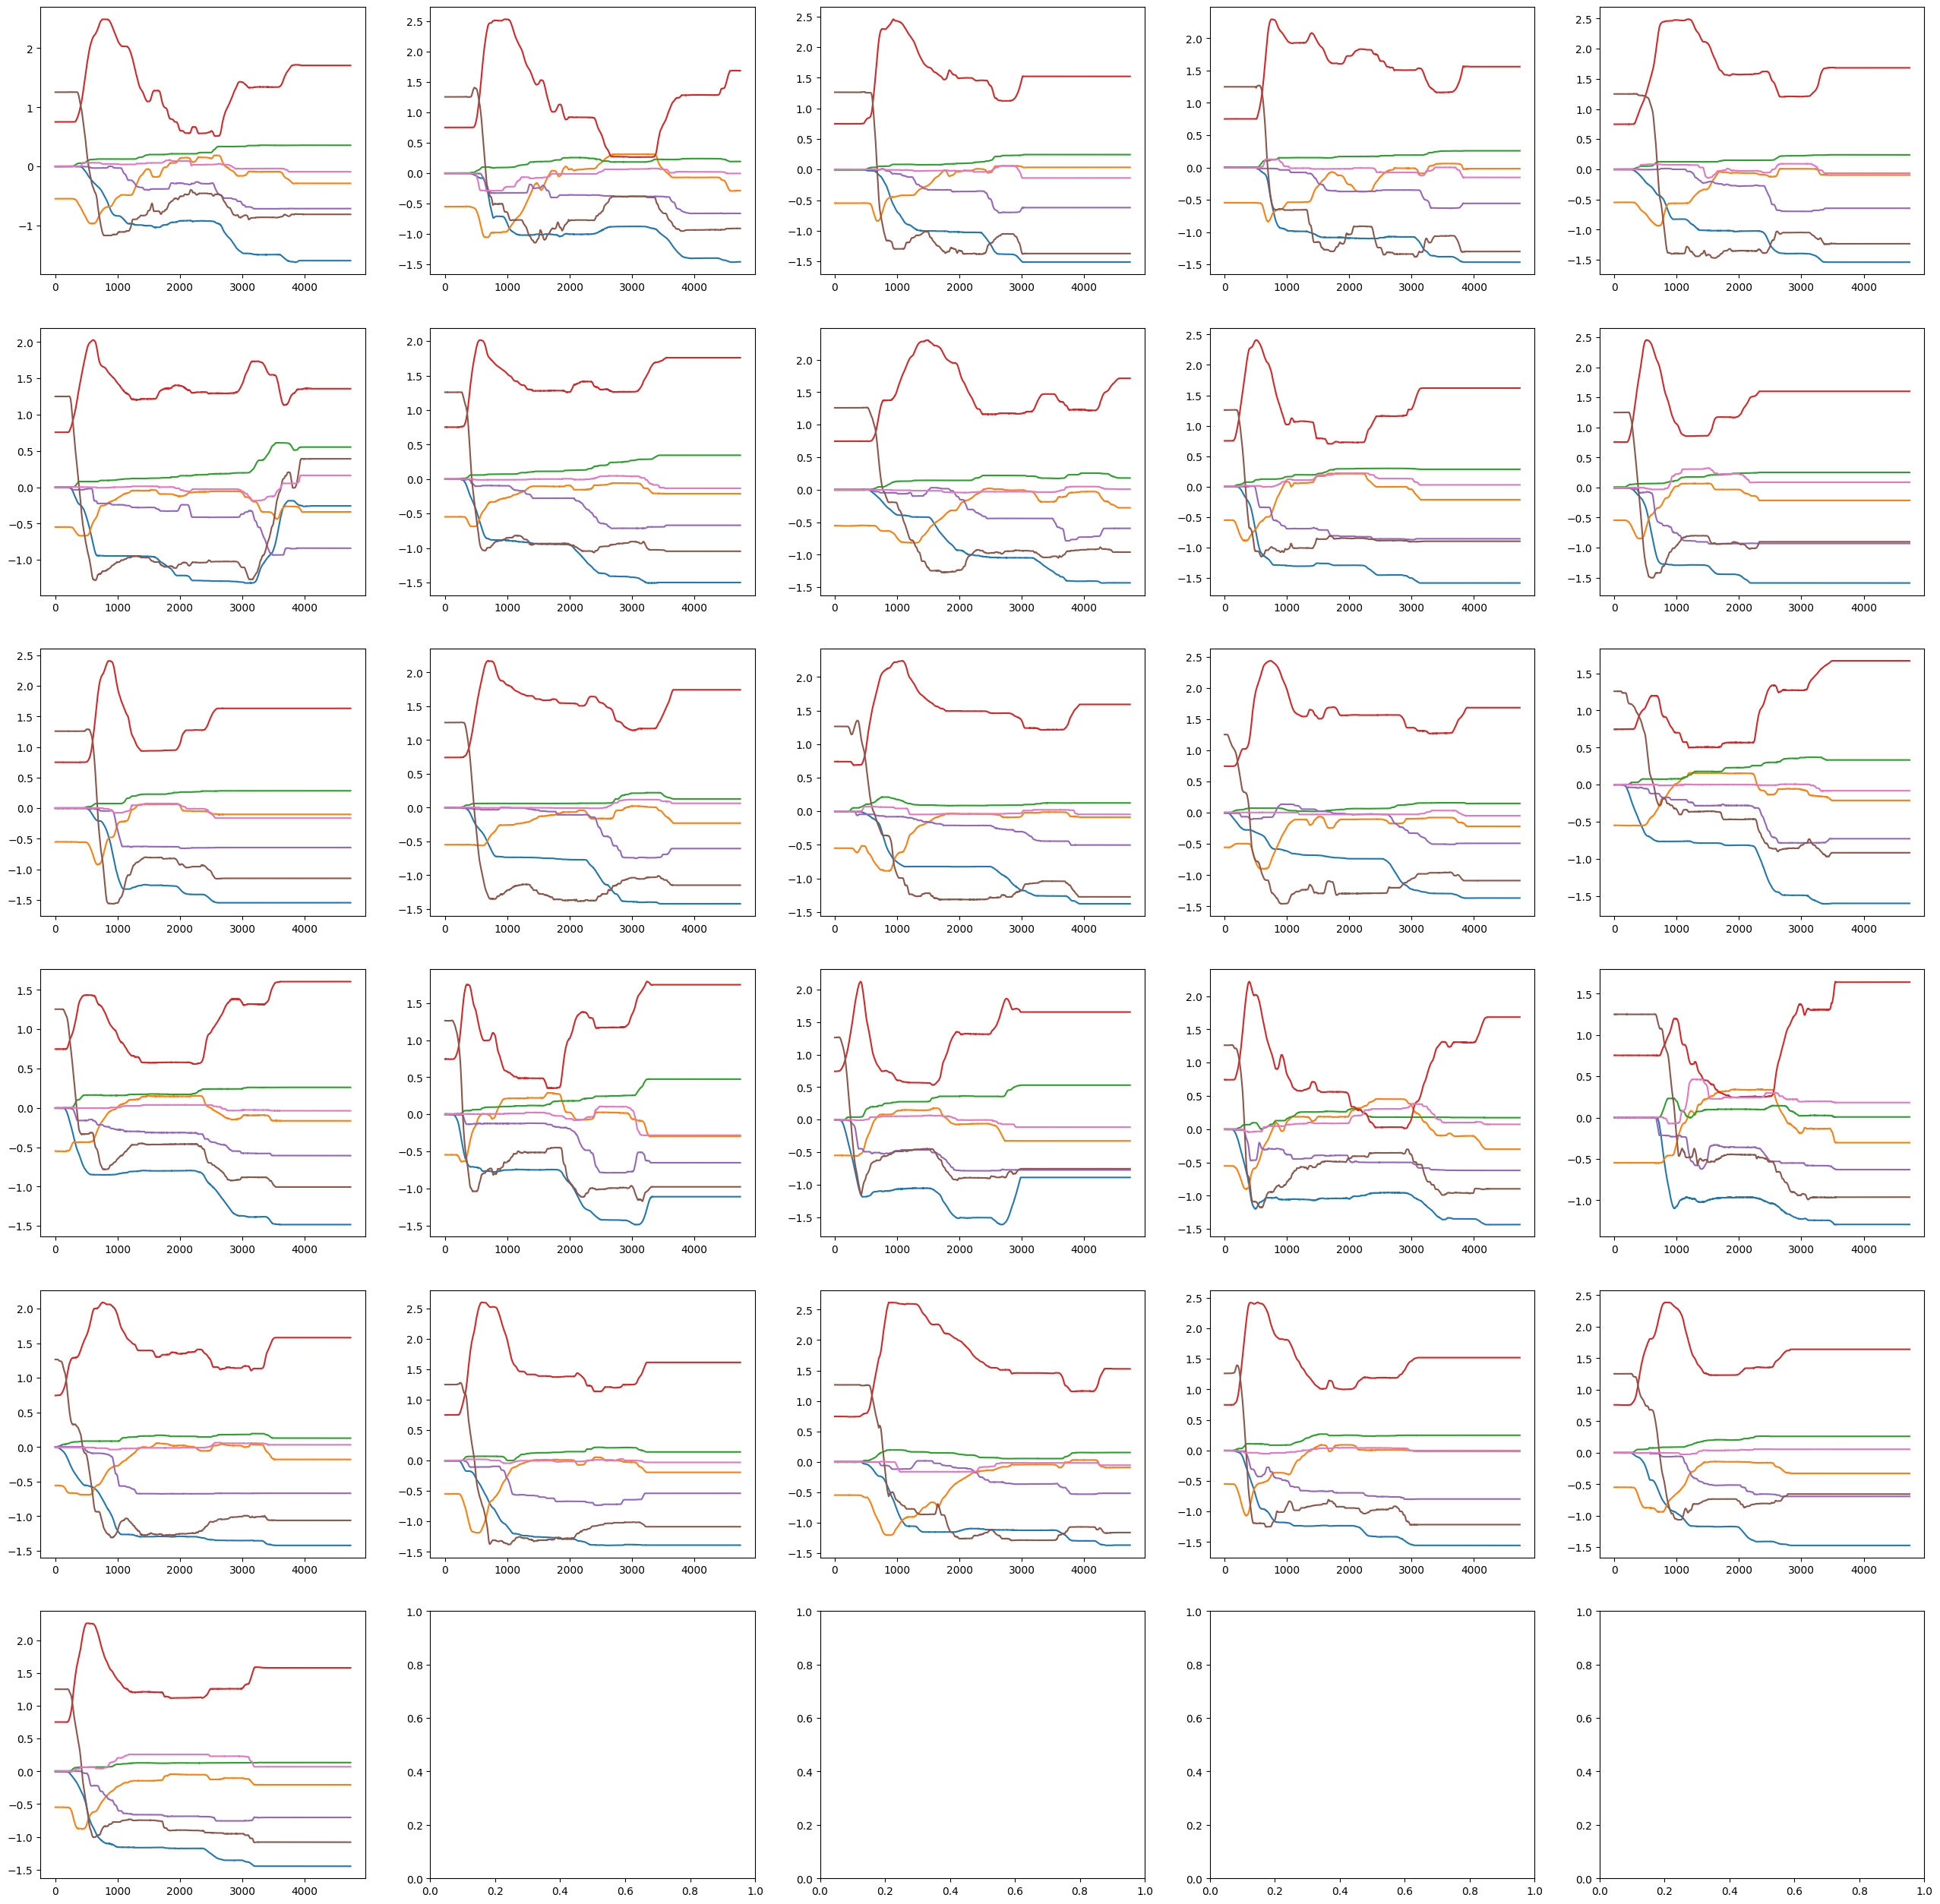

In [7]:
fig, ax = plt.subplots(6, 5, figsize=(32, 32))

for i in range(6):
    for j in range(5):
        it = i * 5 + j
        if(it < len(train_joints)):
            ax[i][j].plot(train_joints[it,:-1,:].T)


# plt.plot(train_joints[0,:-1,:].T)


In [8]:
train_joints[:, :8, :]

array([[[-2.6844663e-03, -2.6844663e-03, -3.0679617e-03, ...,
         -1.5949565e+00, -1.5949565e+00, -1.5949565e+00],
        [-5.4724765e-01, -5.4724765e-01, -5.4724765e-01, ...,
         -2.8723791e-01, -2.8723791e-01, -2.8723791e-01],
        [ 2.3009712e-03,  2.3009712e-03,  3.0679617e-03, ...,
          3.5741752e-01,  3.5741752e-01,  3.5741752e-01],
        ...,
        [ 1.2559468e+00,  1.2559468e+00,  1.2555633e+00, ...,
         -8.1147581e-01, -8.1147581e-01, -8.1147581e-01],
        [ 1.5339808e-03,  1.5339808e-03,  1.9174760e-03, ...,
         -9.0121374e-02, -9.0121374e-02, -9.0121374e-02],
        [ 9.5623985e+01,  9.5623985e+01,  9.5623985e+01, ...,
          9.5623985e+01,  9.5623985e+01,  9.5623985e+01]],

       [[-1.9174760e-03, -1.9174760e-03, -1.9174760e-03, ...,
         -1.4561312e+00, -1.4557477e+00, -1.4568982e+00],
        [-5.4839814e-01, -5.4839814e-01, -5.4801464e-01, ...,
         -2.8608742e-01, -2.8647092e-01, -2.8685442e-01],
        [ 3.4514568e-03, 

In [9]:
def get_train_sample():
    observation = np.zeros((1,n_max,11))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3)) # t, ob_p, w_p  
    gamma = random.randint(0,d_N-1)
    ob_p = train_p[gamma,0]
    w_p = train_p[gamma,1]
    obs_n = random.randint(1,n_max)
    
    perm = np.random.permutation(train_n[gamma])
    
    for i in range(obs_n):
        observation[0,i] = [train_t[gamma,perm[i]],
                            ob_p, # 0,1,2 -> 1/3,2/3,1
                            w_p, # 0,1,2,3 -> 1/4,2/4,3/4,1
                            train_joints[gamma,0,perm[i]],
                            train_joints[gamma,1,perm[i]],
                            train_joints[gamma,2,perm[i]],
                            train_joints[gamma,3,perm[i]],
                            train_joints[gamma,4,perm[i]],
                            train_joints[gamma,5,perm[i]],
                            train_joints[gamma,6,perm[i]],
                            train_joints[gamma,7,perm[i]]
                           ]
        observation_flag[0,0,i] = 1./obs_n
    target[0,0] = [train_t[gamma,perm[obs_n]], ob_p, w_p]
    return [observation,observation_flag,target], \
            [[[[train_joints[gamma,0,perm[obs_n]],
                train_joints[gamma,1,perm[obs_n]],
                train_joints[gamma,2,perm[obs_n]],
                train_joints[gamma,3,perm[obs_n]],
                train_joints[gamma,4,perm[obs_n]],
                train_joints[gamma,5,perm[obs_n]],
                train_joints[gamma,6,perm[obs_n]],
                train_joints[gamma,7,perm[obs_n]],
                0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
                ]]]],gamma

In [10]:
def custom_loss(y_true, y_pred):
    mean, log_sigma = tf.split(y_pred, 2, axis=-1)
    y_target, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_target))
    return loss

In [11]:
observation_layer = Input(shape=(n_max,11))
observation_flag_layer=Input(shape=(1,n_max)) 
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128))(observation_encoded)
matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,128))
representation=matmul_layer([observation_flag_layer,observation_encoded])
target_layer = Input(shape=(1,3))
query_net_input = Concatenate(axis=2)([representation, target_layer])
query = Dense(128, activation='relu')(query_net_input)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
output_layer = Dense(16)(query)
model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 11)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 128)      1536        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 5, 128)      16512       ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

c:\Users\dmtya\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
#TODO: I MODIFIED HERE
import gc
# train_loss = np.zeros(2000)
min_iterations = 200000
max_iterations=200000
save_model_name = "task_parametrization_left_200kfixed_all.h5"
if train_side == "right":
    save_model_name = "task_parametrization_right_200kfixed_all.h5"

for step in range(min_iterations, max_iterations):
    inp,out,gamma = get_train_sample()
    out = np.array(out)
    data = model.fit(inp,out,batch_size=3,verbose=0)

    if step % 1000 == 0:
        train_loss[step//1000] = data.history['loss'][0]
        tf.keras.backend.clear_session()
        gc.collect()
    if step % 10000 == 0:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( 'step:', step)
        print( 'loss:', data.history['loss'][0])
        plt.title('Train Loss')
        plt.plot(range(2000),train_loss)
        plt.show()
        mean_loss = np.zeros((100))
        for i in range(100):
            mean_loss[i] = np.mean(train_loss[i*20:(i+1)*20])
        fig = plt.figure()
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(100),mean_loss)
        plt.show()
        model.save(save_model_name)
        plt_predictions(0)

In [13]:
train_joints[0,:,0]

array([-2.6844663e-03, -5.4724765e-01,  2.3009712e-03,  7.5241756e-01,
       -3.4514568e-03,  1.2559468e+00,  1.5339808e-03,  9.5623985e+01],
      dtype=float32)

In [14]:
import keras.losses
keras.losses.custom_loss = custom_loss
from keras.models import load_model

model = load_model('./trained_models/task_parametrization_left1m.h5', custom_objects={ 'tf':tf })

ValueError: bad marshal data (unknown type code)

In [ ]:
aaaaa= train_joints[0,1,:]

In [ ]:
print(aaaaa[:10])

[-0.54839814 -0.54801464 -0.5491651  -0.54878163 -0.54839814 -0.54839814
 -0.54878163 -0.54878163 -0.54878163 -0.54839814]


In [ ]:
n_max

1

In [ ]:
prediction = np.zeros((8,train_n[0]))
prediction_std = np.zeros((8,train_n[0])) #TODO: 6?
observation = np.zeros((1,n_max,11))
observation_flag = np.zeros((1,1,n_max))
target = np.zeros((1,1,3))
ob_p=train_p[0,0]
w_p=train_p[0,1]
observation[0,0] = [0,ob_p,w_p,
                        train_joints[0,0,0],
                        train_joints[0,1,0],
                        train_joints[0,2,0],
                        train_joints[0,3,0],
                        train_joints[0,4,0],
                        train_joints[0,5,0],
                        train_joints[0,6,0],
                        train_joints[0,7,0]]

observation_flag[0,0,0] = 1.
joint_names = ['a','b','c','d','e','f','g','h']        
for x, i in enumerate(train_t[0]):
    target[0,0] = [i,ob_p,w_p]
    p = model.predict([observation,observation_flag,target])[0][0]
    prediction[:,x] = p[:8]

1/1 [==============================] - 0s 26ms/step


In [ ]:
prediction.shape

(8, 4107)

In [ ]:
prediction

array([[ 7.81580806e-04,  7.99238682e-04,  8.16926360e-04, ...,
        -1.37674403e+00, -1.37675118e+00, -1.37675846e+00],
       [-5.48710823e-01, -5.48737586e-01, -5.48764527e-01, ...,
        -8.96345079e-02, -8.96426588e-02, -8.96508545e-02],
       [-1.98724866e-03, -1.98822096e-03, -1.98916718e-03, ...,
         1.24184772e-01,  1.24183133e-01,  1.24181494e-01],
       ...,
       [-5.65988159e+00, -5.65958357e+00, -5.65928555e+00, ...,
        -6.36267996e+00, -6.36316824e+00, -6.36365843e+00],
       [-6.33833218e+00, -6.33836842e+00, -6.33840322e+00, ...,
        -7.15247774e+00, -7.15273380e+00, -7.15299129e+00],
       [-5.27192450e+00, -5.27160645e+00, -5.27128983e+00, ...,
        -5.02974939e+00, -5.03012466e+00, -5.03049803e+00]])

In [ ]:
observation[0,0]

array([ 0.        ,  0.57734376,  0.80859375, -0.00268447, -0.13729128,
       -0.00345146,  0.12923788,  0.97867972,  0.00268447,  0.39346609,
        0.00191748])

In [ ]:
observation.shape

(1, 1, 11)

In [ ]:
observation_flag

array([[[1.]]])

In [ ]:
a,b,c,d = data_format.data_per_trajectory('./carry_data/train3', True)
m_pred = np.array(a)[:, :8, :].T #for left arm


/home/colors/Desktop/Cappuccino-Preparing-Robot-Baxter/data_format.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), max_size


In [ ]:
prediction.T.shape

(4107, 8)

In [ ]:
m_pred[:,:,0].shape

(4107, 8)

In [ ]:
real_pred = np.concatenate([prediction.T, m_pred[:,:,0]], axis=1)

In [ ]:
real_pred.shape

(4107, 16)

In [ ]:
traj_time = prediction.shape[1]


In [ ]:
values.shape

(3866, 16)

In [ ]:
times = np.linspace(0,1,traj_time)

In [ ]:
times = times.reshape(times.size,1)

In [ ]:

values = real_pred

headers = np.array(["time","left_s0","left_s1","left_e0","left_e1","left_w0","left_w1","left_w2","left_gripper","right_s0","right_s1","right_e0","right_e1","right_w0","right_w1","right_w2","right_gripper"])
headers = headers.reshape(1,17)



In [ ]:
headers.shape

(1, 17)

In [ ]:
values = np.hstack((times,values))


In [ ]:
record = np.vstack((headers,values))

array([['time', 'left_s0', 'left_s1', ..., 'right_w1', 'right_w2',
        'right_gripper'],
       ['0.0', '0.0007815808057785034', '-0.548710823059082', ...,
        '1.2643836736679077', '0.0015339808305725455',
        '95.62398529052734'],
       ['0.00024354603019970775', '0.0007992386817932129',
        '-0.5487375855445862', ..., '1.263616681098938',
        '0.0026844663079828024', '95.62398529052734'],
       ...,
       ['0.9995129079396006', '-1.376744031906128',
        '-0.08963450789451599', ..., '-1.2735875844955444',
        '-0.04525243490934372', '95.62398529052734'],
       ['0.9997564539698003', '-1.376751184463501',
        '-0.08964265882968903', ..., '-1.2735875844955444',
        '-0.04525243490934372', '95.62398529052734'],
       ['1.0', '-1.3767584562301636', '-0.08965085446834564', ...,
        '-1.2735875844955444', '-0.04525243490934372',
        '95.62398529052734']], dtype='<U32')

In [ ]:
file_name = "./trajectories/output_" + str(1) + ".csv"
np.savetxt(file_name, record, delimiter=',', fmt='%s')

In [ ]:
traj_time = prediction.shape[1]
times = np.linspace(traj_time)
headers = np.array(["time","left_s0","left_s1","left_e0","left_e1","left_w0","left_w1","left_w2","left_gripper"])

prediction.T

values = predicted_trajectory[0].squeeze(0).detach().numpy()
headers = headers.reshape(1,17)

time_len = values.shape[0]
times = np.arange(0.45, 0.45 + time_len * 0.01, 0.01).reshape(-1, 1)
values = np.hstack((times,values))
record = np.vstack((headers,values))

file_name = "./trajectories/output_" + str(self.index) + ".csv"
self.index = self.index + 1
np.savetxt(file_name, record, delimiter=',', fmt='%s')

(8, 3866)